<a href="https://www.kaggle.com/code/saswattulo/image-classification-using-tinyvgg?scriptVersionId=192782773" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Weather Classification using TinyVGG CNN Architecture

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm


import torch
from torch import nn
from torchvision import transforms
from torchinfo import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import shutil

from PIL import Image
import requests
from io import BytesIO

device="cuda" if torch.cuda.is_available() else "cpu"

In [2]:
torch.__version__,device

('2.1.2', 'cuda')

In [3]:
# Define paths
dataset_dir = '/kaggle/input/weather-dataset/dataset'  # Original dataset directory
data_dir = '/kaggle/working/'        # Directory where 'data' folder will be created

# Create data directory with train and test subfolders
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each class folder in the original dataset
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):
        # Create class folders in train and test directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Get list of all images in the current class directory
        images = os.listdir(class_path)
        
        # Split images into train and test sets
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        
        # Move images to the corresponding directories
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
            
        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

print("Dataset successfully split into 'data/train' and 'data/test' sets.")

Dataset successfully split into 'data/train' and 'data/test' sets.


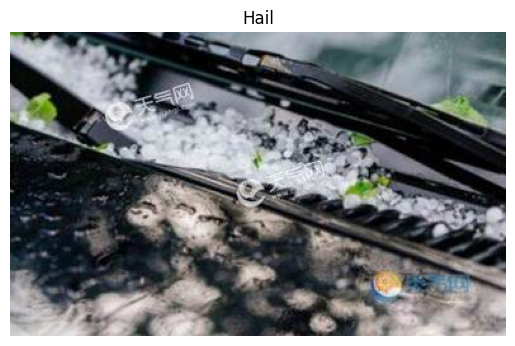

In [4]:
from PIL import Image

hail_image_path="/kaggle/working/train/hail/0568.jpg"

img=Image.open(hail_image_path)

plt.imshow(img)
plt.axis(False)
plt.title("Hail")
plt.show()

In [5]:
train_data_transforms=transforms.Compose([transforms.Resize(size=(128,128)),
                                         transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.RandomVerticalFlip(p=0.5),
                                         transforms.ToTensor()])
test_data_transforms=transforms.Compose([transforms.Resize(size=(128,128)),
                                         transforms.ToTensor()])

In [6]:
train_folder=ImageFolder(root=train_dir,
                         transform=train_data_transforms,
                         target_transform=None)
test_folder=ImageFolder(root=test_dir,
                        transform=test_data_transforms)

classes_name=train_folder.classes

In [7]:
train_data_loader=DataLoader(dataset=train_folder,
                             batch_size=32,
                             shuffle=True)
test_data_loader=DataLoader(dataset=test_folder,
                            batch_size=32,
                            shuffle=False)

In [8]:
len(train_data_loader),len(test_data_loader)

(172, 44)

In [9]:
class TinyVGG(nn.Module):
    def __init__(self,input_size:int,output_size:int,hidden_units:int):
        super().__init__()
        self.block_1=nn.Sequential(nn.Conv2d(in_channels=input_size,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=0,stride=1),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=3,stride=1))
        self.block_2=nn.Sequential(nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=3,stride=1))
        self.classifier_block=nn.Sequential(nn.Flatten(),
                                            nn.Linear(in_features=215296,out_features=output_size))
        
    def forward(self,x):
        x=self.block_1(x)
#         print(x.shape)
        x=self.block_2(x)
#         print(x.shape)
        x=self.classifier_block(x)
#         print(x.shape)
        return x

In [10]:
weather_classifier=TinyVGG(input_size=3,hidden_units=16,output_size=len(classes_name))
img,label=next(iter(train_data_loader))
summary(model=weather_classifier,input_data=img,batch_dim=32)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 11]                  --
├─Sequential: 1-1                        [32, 16, 122, 122]        --
│    └─Conv2d: 2-1                       [32, 16, 126, 126]        448
│    └─ReLU: 2-2                         [32, 16, 126, 126]        --
│    └─Conv2d: 2-3                       [32, 16, 124, 124]        2,320
│    └─ReLU: 2-4                         [32, 16, 124, 124]        --
│    └─MaxPool2d: 2-5                    [32, 16, 122, 122]        --
├─Sequential: 1-2                        [32, 16, 116, 116]        --
│    └─Conv2d: 2-6                       [32, 16, 120, 120]        2,320
│    └─ReLU: 2-7                         [32, 16, 120, 120]        --
│    └─Conv2d: 2-8                       [32, 16, 118, 118]        2,320
│    └─ReLU: 2-9                         [32, 16, 118, 118]        --
│    └─MaxPool2d: 2-10                   [32, 16, 116, 116]        --
├─Seq

In [11]:
def train_step(model:nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               optimizer:torch.optim,
               loss_function:nn.Module,
               device:torch.device=device):
    
    # put the model into device
    model=model.to(device)
    
    # activate train mode
    model.train()
    
    # set up model metrics
    training_acc,training_loss=0,0
    
    # iterate through the batches of train dataloader
    for batch,(X,y) in enumerate(train_data_loader):
        
        # put X and y into given hardware device
        X=X.to(device)
        y=y.to(device)
        
        # forward pass
        y_pred=model(X)
        
        # calculate the training loss
        train_loss=loss_function(y_pred,y)
        training_loss+=train_loss.item()
        
        # zero grad the optimizer
        optimizer.zero_grad()
        
        # backward propagation
        train_loss.backward()
        
        # parameter updation
        optimizer.step()
        
        # calculate the accuracy
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        training_acc+=(y_pred_class==y).sum().item()/len(y)
        
    # adjust the training metrics for batchs
    training_acc/=len(train_dataloader)
    training_loss/=len(train_dataloader)
    
    return training_loss,training_acc

In [12]:
def test_step(model:nn.Module,
              loss_function:nn.Module,
              test_dataloader:torch.utils.data.DataLoader,
              device:torch.device=device):
    
    # put the model into the desired device
    model=model.to(device)
    
    # set up model evaluate metrics
    testing_acc=0
    testing_loss=0
    
    # activate eval
    model.eval()
    
    with torch.inference_mode():
        # iterration starts here
        for batch,(X,y) in enumerate(test_data_loader):

            # put the X and y into given device
            X=X.to(device)
            y=y.to(device)

            # forward propagation
            y_pred=model(X)

            # calculate test_loss
            test_loss=loss_function(y_pred,y)
            testing_loss+=test_loss.item()

            y_pred_class=y_pred.argmax(dim=1)

            testing_acc+=(y_pred_class==y).sum().item()/len(y)
        
    
    # adjust the metrics
    testing_acc=testing_acc/len(test_data_loader)
    testing_loss=testing_loss/len(test_data_loader)
    
    return testing_loss,testing_acc

In [13]:
from tqdm.auto import tqdm

def train(model:nn.Module,
                  train_dataloader:torch.utils.data.DataLoader,
                  test_dataloader:torch.utils.data.DataLoader,
                  optimizer:torch.optim,
                  loss_function:nn.Module,
                  epochs:int=3,
                  device:torch.device=device):
    
    # create empty results dictionary
    results={"training_loss":[],
            "training_acc":[],
            "testing_loss":[],
            "testing_acc":[]
           }
    
    
    for epoch in tqdm(range(epochs),desc="Model training in progress"):
        # train the model
        train_loss,train_acc=train_step(model=model,
                                        train_dataloader=train_data_loader,
                                        optimizer=optimizer,
                                        loss_function=loss_function,
                                        device=device)

        # test the model
        test_loss,test_acc=test_step(model=model,
                                     test_dataloader=test_data_loader,
                                     loss_function=loss_function,
                                     device=device)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
    
        results['training_loss'].append(train_loss)
        results['training_acc'].append(train_acc)
        results['testing_loss'].append(test_loss)
        results['testing_acc'].append(test_acc)
    
    return results

In [14]:
# creating a model
model=TinyVGG(input_size=3,hidden_units=16,output_size=len(classes_name)).to(device)

# optimizer
optimizer=torch.optim.Adagrad(params=model.parameters(),lr=0.01)

# loss function
loss_function=nn.CrossEntropyLoss()

epochs=80

In [15]:
results=train(model=model,
      train_dataloader=train_data_loader,
      test_dataloader=test_data_loader,
      loss_function=loss_function,
      optimizer=optimizer,device=device,epochs=epochs)

Model training in progress:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5709 | train_acc: 0.1639 | test_loss: 2.3726 | test_acc: 0.1648
Epoch: 2 | train_loss: 2.3670 | train_acc: 0.1689 | test_loss: 2.3627 | test_acc: 0.1648
Epoch: 3 | train_loss: 2.3589 | train_acc: 0.1686 | test_loss: 2.3565 | test_acc: 0.1648
Epoch: 4 | train_loss: 2.3534 | train_acc: 0.1689 | test_loss: 2.3521 | test_acc: 0.1648
Epoch: 5 | train_loss: 2.3492 | train_acc: 0.1692 | test_loss: 2.3488 | test_acc: 0.1648
Epoch: 6 | train_loss: 2.3461 | train_acc: 0.1692 | test_loss: 2.3462 | test_acc: 0.1648
Epoch: 7 | train_loss: 2.3435 | train_acc: 0.1695 | test_loss: 2.3441 | test_acc: 0.1648
Epoch: 8 | train_loss: 2.3417 | train_acc: 0.1695 | test_loss: 2.3425 | test_acc: 0.1648
Epoch: 9 | train_loss: 2.3403 | train_acc: 0.1692 | test_loss: 2.3411 | test_acc: 0.1648
Epoch: 10 | train_loss: 2.3388 | train_acc: 0.1692 | test_loss: 2.3399 | test_acc: 0.1648
Epoch: 11 | train_loss: 2.3376 | train_acc: 0.1692 | test_loss: 2.3389 | test_acc: 0.1648
Epoch: 12 | train_l

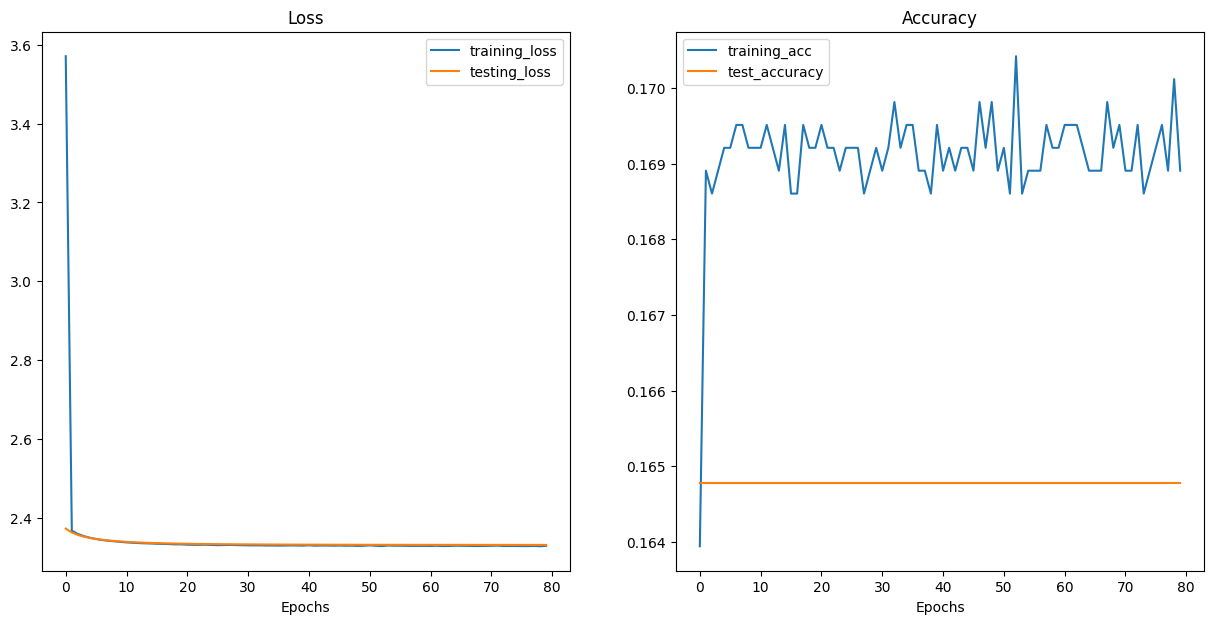

In [16]:
from typing import Tuple,List,Dict

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"training_loss": [...],
             "training_acc": [...],
             "testing_loss": [...],
             "testing_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['training_loss']
    test_loss = results['testing_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['training_acc']
    test_accuracy = results['testing_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['training_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, test_loss, label='testing_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='training_acc')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
plot_loss_curves(results)

Fetching Image from Web


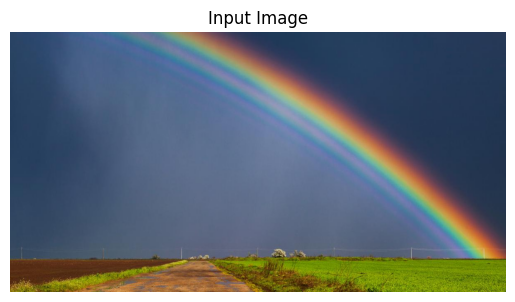

Predicted class: rime


In [17]:
def predict_from_url(model, image_url, classes_name):
    # Define the image transformation
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize the image to 128x128
        transforms.ToTensor()           # Convert the image to a PyTorch tensor
    ])
    
    print("Fetching Image from Web")
    # Load the image from the URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert("RGB")  # Ensure the image has 3 channels (RGB)
    
    # Display the image
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()
    
    # Apply the transformations
    img = transform(img)
    
    # Add a batch dimension
    img = img.unsqueeze(0)
    
    # Move the image to the device (GPU/CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = img.to(device)
    model = model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Make the prediction
    with torch.inference_mode():
        output = model(img)
        _, predicted = torch.max(output, 1)
    
    # Print the prediction
    print(f"Predicted class: {classes_name[predicted.item()]}")

image_url = "https://c.tadst.com/gfx/1200x630/rainbow.jpg"
prediction = predict_from_url(model, image_url,classes_name=classes_name)

## Conclusion and Next Steps

In this notebook, we developed a weather prediction model using TinyVGG and PyTorch. The model was trained for 80 epochs, achieving a training accuracy of 90.73% and a test accuracy of 61.86%. While these results are promising, there's room for improvement, particularly in reducing the test loss, which currently stands at 1.6120.

## Suggestions for Further Improvement

1. **Train for More Epochs**: Given the gap between training and test accuracy, it would be beneficial to train the model for additional epochs. This could help the model generalize better to the test data.

2. **Data Augmentation**: Experimenting with different data augmentation techniques could improve the model's robustness and performance.

3. **Learning Rate Adjustment**: Tuning the learning rate, either by reducing it gradually or using learning rate schedulers, might help achieve better convergence.

4. **Model Architecture Tweaks**: Exploring different architectures or making adjustments to TinyVGG could potentially enhance the model's accuracy.

## Call to Action

I encourage you to fork this notebook and experiment with these suggestions. Feel free to tweak the model parameters, train for longer epochs, and share your findings. Every iteration brings us closer to a more accurate weather prediction model!

## Happy coding!
